In [1]:
!pip install transformers

In [2]:
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
import torch

# Load backtranslation model and tokenizer
def load_translation_model(src_lang, tgt_lang):
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return model, tokenizer

# Translate text in batches
def translate_text(texts, model, tokenizer, device='cpu', batch_size=8):
    model = model.to(device)
    translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model.generate(**inputs)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(decoded)
    return translations

# Backtranslate texts
def backtranslate_texts(texts, device='cpu'):
    # Load translation models
    en_to_fr_model, en_to_fr_tokenizer = load_translation_model('en', 'fr')
    fr_to_en_model, fr_to_en_tokenizer = load_translation_model('fr', 'en')

    # Step 1: Translate to French
    translated_to_fr = translate_text(texts, en_to_fr_model, en_to_fr_tokenizer, device)

    # Step 2: Translate back to English
    backtranslated = translate_text(translated_to_fr, fr_to_en_model, fr_to_en_tokenizer, device)

    return backtranslated

# Load dataset
dataset_path = '/content/labeled_data_cleaned_whole.csv'
data = pd.read_csv(dataset_path)

# Clean missing values
data['corrected_tweet'] = data['corrected_tweet'].fillna('')
data['corrected_tweet'] = data['corrected_tweet'].astype(str)

# Separate the hate speech class (class 0)
class_0 = data[data['class'] == 0]

# Augment class 0 with backtranslation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
augmented_texts = backtranslate_texts(class_0['corrected_tweet'].tolist(), device)

# Create a new DataFrame for augmented data
augmented_class_0 = pd.DataFrame({
    'corrected_tweet': augmented_texts,
    'class': [0] * len(augmented_texts)
})

# Combine augmented data with the original dataset
augmented_data = pd.concat([data, augmented_class_0])
augmented_data = augmented_data.sample(frac=1, random_state=42)

# Save the augmented dataset
augmented_dataset_path = '/content/augmented_dataset.csv'
augmented_data.to_csv(augmented_dataset_path, index=False)
print(f"Augmented dataset saved to {augmented_dataset_path}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Augmented dataset saved to /content/augmented_dataset.csv


In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

# Load Dataset
dataset_path = '/content/augmented_dataset.csv'
data = pd.read_csv(dataset_path)

# Handle missing values
data['corrected_tweet'] = data['corrected_tweet'].fillna('')
data['corrected_tweet'] = data['corrected_tweet'].astype(str)

# Separate texts and labels
texts = data['corrected_tweet'].values
labels = data['class'].values

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize Dataset with Reduced Sequence Length
def tokenize_texts(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

# Convert Labels to Tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Define Custom Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create Datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Load Pretrained mBERT Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=3  # Number of classes
)

# Unfreeze all layers
for param in model.bert.parameters():
    param.requires_grad = True

# Define class weights
class_weights = torch.tensor([5.0, 1.0, 2.0])

# Custom Trainer with Weighted Loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        class_weights_device = class_weights.to(logits.device)
        loss_fn = CrossEntropyLoss(weight=class_weights_device)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
)

# Trainer with Weighted Loss
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda pred: {
        'accuracy': accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        'precision': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[0],
        'recall': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[1],
        'f1': precision_recall_fscore_support(
            pred.label_ids, pred.predictions.argmax(-1), average='weighted'
        )[2],
    }
)

# Train the Model
trainer.train()

# Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the Model
model.save_pretrained('./mbert_hate_speech')
tokenizer.save_pretrained('./mbert_hate_speech')

# Predict on Validation Set
val_outputs = trainer.predict(val_dataset)
preds = val_outputs.predictions.argmax(-1)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report:")
print(classification_report(val_labels, preds, target_names=['Hate Speech', 'Offensive', 'Neutral'], zero_division=0))

# Confusion Matrix
cm_normalized = confusion_matrix(val_labels, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-794df39abb7c>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.411900,0.441397,0.905588,0.907469,0.905588,0.906119
2,0.331400,0.400911,0.908068,0.911759,0.908068,0.909061
3,0.290900,0.395058,0.908640,0.912296,0.908640,0.910128


Evaluation Results: {'eval_loss': 0.3950580060482025, 'eval_accuracy': 0.908640091550639, 'eval_precision': 0.9122955837252598, 'eval_recall': 0.908640091550639, 'eval_f1': 0.9101284287810711, 'eval_runtime': 5.0882, 'eval_samples_per_second': 1030.422, 'eval_steps_per_second': 32.231, 'epoch': 3.0}
Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.67      0.74      0.71       557
   Offensive       0.96      0.93      0.94      3861
     Neutral       0.87      0.91      0.89       825

    accuracy                           0.91      5243
   macro avg       0.83      0.86      0.85      5243
weighted avg       0.91      0.91      0.91      5243



NameError: name 'cm' is not defined

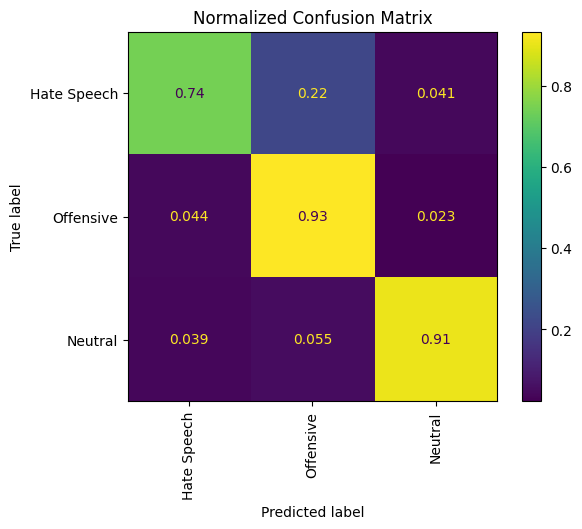

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)
cm_normalized = confusion_matrix(val_labels, preds, normalize='true')

# Use cm_normalized for the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                               display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()